In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# Hyperparameters

IMAGE_SIZE = 32
BATCH_SIZE = 64


# Transform: [0,1] -> [-1,1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5, 0.5, 0.5),
        std=(0.5, 0.5, 0.5)
    )
])


train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True
)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True,
    pin_memory=True   
)

print("Total Images:", len(train_dataset))


Total Images: 50000


In [19]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [20]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [21]:
import matplotlib.pyplot as plt

def show_images(dataset, num_samples=20, cols=4):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        img, _ = dataset[i]     
        img = (img + 1) / 2     
        img = img.permute(1, 2, 0)  

        plt.subplot(num_samples // cols + 1, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()


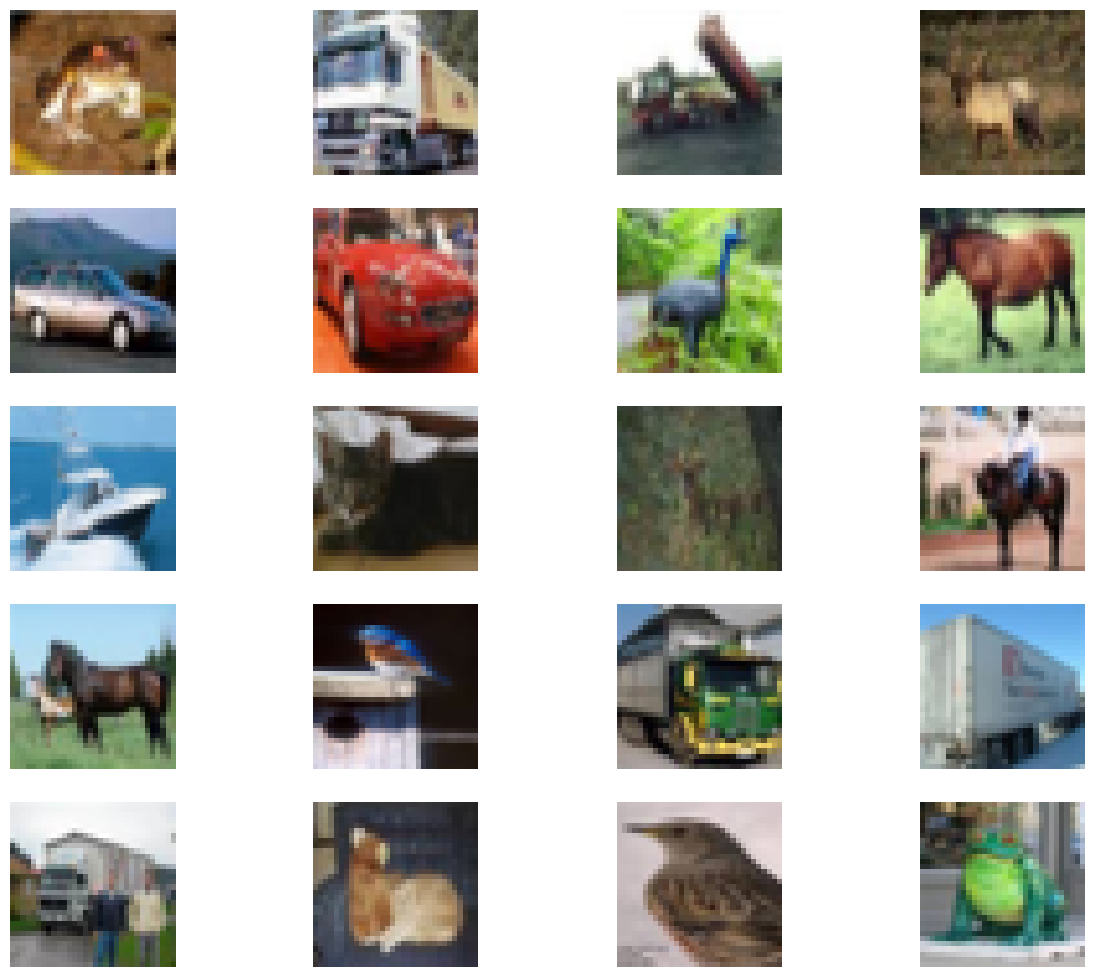

In [22]:
show_images(train_dataset)


In [ ]:
import torch
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=1e-4, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    vals: Tensor of shape [T]
    t: Tensor of shape [B]
    x_shape: (B, C, H, W)
    """
    batch_size = t.shape[0]
    out = vals.gather(0, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t):
    """
    x_0: clean images (B, C, H, W)
    t: timesteps (B,)
    """
    noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t = get_index_from_list(
        sqrt_alphas_cumprod, t, x_0.shape
    )
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    x_t = (
        sqrt_alphas_cumprod_t * x_0 +
        sqrt_one_minus_alphas_cumprod_t * noise
    )

    return x_t, noise

T = 300  # number of diffusion steps

betas = linear_beta_schedule(T).to(device)
alphas = 1.0 - betas

alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

posterior_variance = (
    betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
)


In [24]:
x, _ = next(iter(train_loader))
x = x.to(device)

t = torch.randint(0, T, (x.size(0),), device=device)
x_t, noise = forward_diffusion_sample(x, t)

print(x_t.shape, x_t.device)


torch.Size([64, 3, 32, 32]) cuda:0


In [30]:
import matplotlib.pyplot as plt

def visualize_forward_diffusion_grid(
    dataset,
    timesteps,
    num_images=5
):
    """
    Rows: different images
    Columns: different timesteps
    """
    plt.figure(figsize=(3 * len(timesteps), 3 * num_images))

    for img_idx in range(num_images):
        img, _ = dataset[img_idx]
        img = img.unsqueeze(0).to(device)  # (1, C, H, W)

        for t_idx, t in enumerate(timesteps):
            t_tensor = torch.tensor([t], device=device)
            x_t, _ = forward_diffusion_sample(img, t_tensor)

            # unnormalize for display
            x_t = (x_t + 1) / 2
            x_t = x_t.squeeze(0).permute(1, 2, 0).cpu()

            plt.subplot(num_images, len(timesteps),
                        img_idx * len(timesteps) + t_idx + 1)
            plt.imshow(x_t)
            plt.axis("off")

            if img_idx == 0:
                plt.title(f"t = {t}")

    plt.suptitle("Forward Diffusion Process", fontsize=16)
    plt.show()


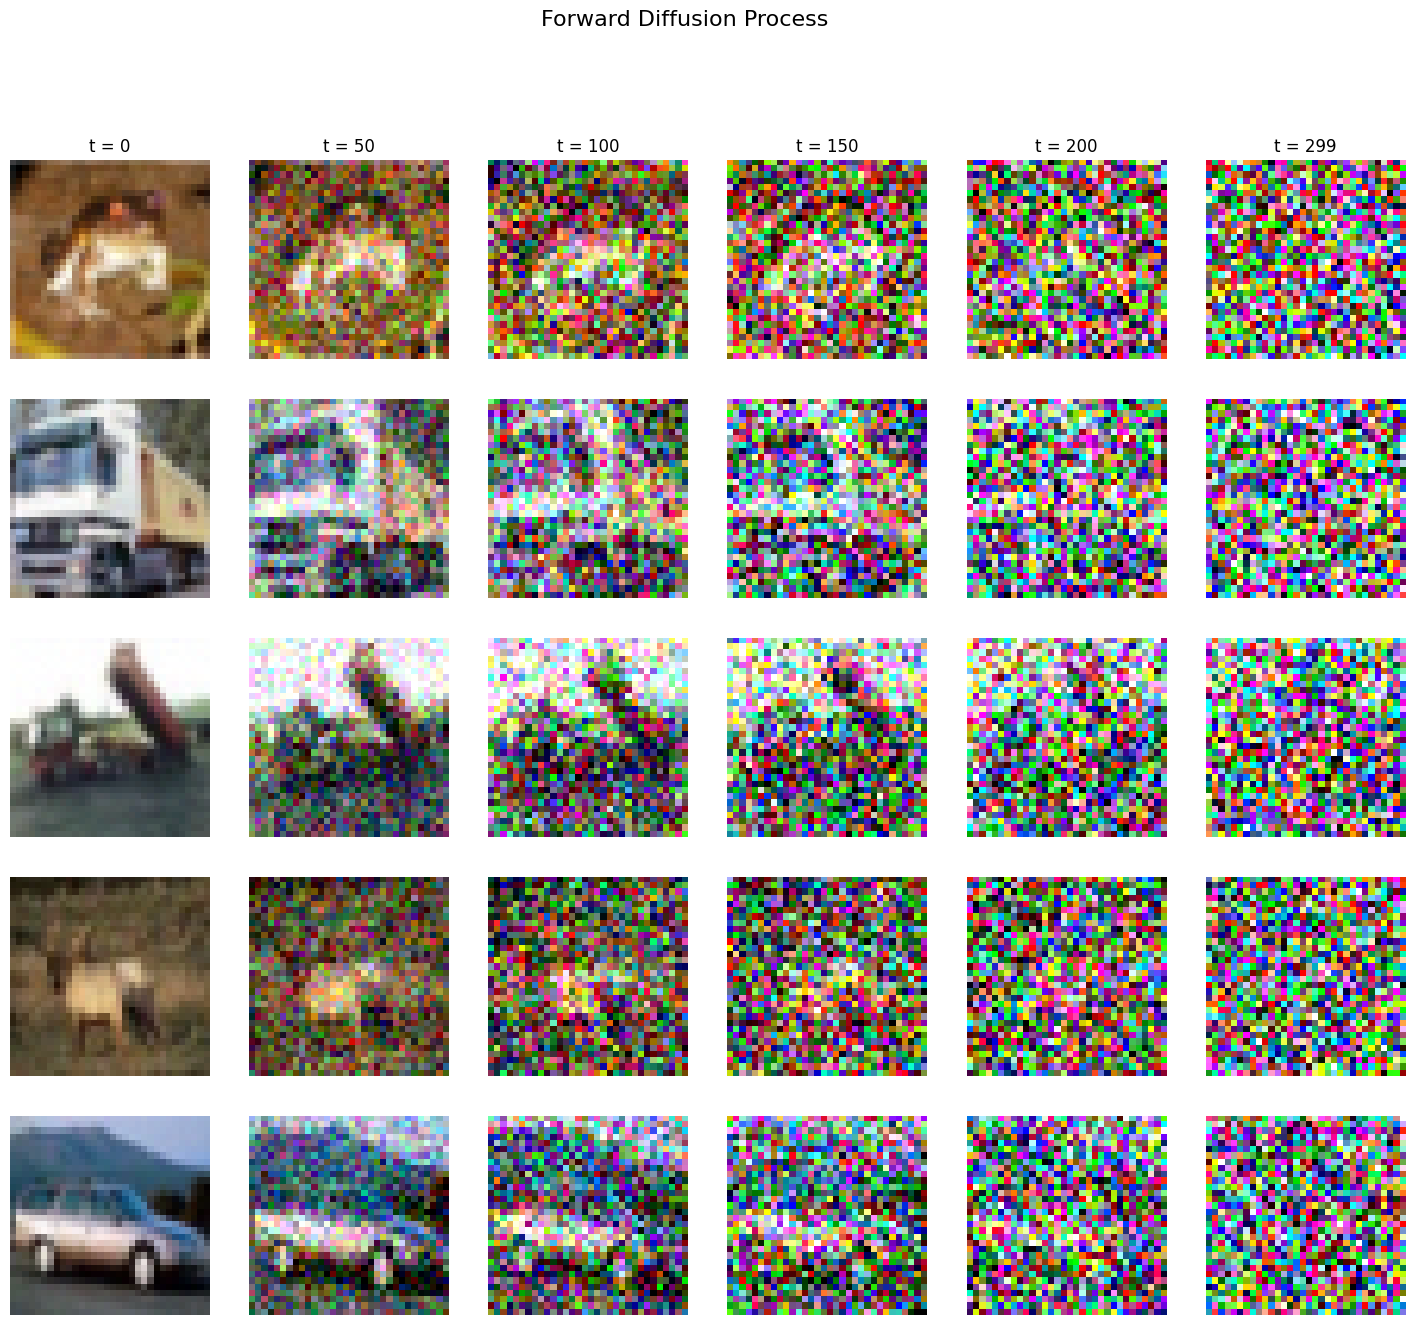

In [31]:
timesteps = [0, 50, 100, 150, 200, 299]

visualize_forward_diffusion_grid(
    train_dataset,
    timesteps=timesteps,
    num_images=5
)
